In [ ]:
!pip install keras-preprocessing


In [ ]:
from keras.utils import to_categorical
from keras_preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np

In [ ]:
!pip install kagglehub


Downloading the dataset


In [ ]:
import kagglehub
dataset_path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
print("Dataset downloaded to:", dataset_path)

Using Colab cache for faster access to the 'face-expression-recognition-dataset' dataset.
Dataset downloaded to: /kaggle/input/face-expression-recognition-dataset


Set correct paths


In [ ]:
# Set correct folder paths
IMAGES_DIR = os.path.join(dataset_path, 'images')
TRAIN_DIR = os.path.join(IMAGES_DIR, 'train')
VAL_DIR   = os.path.join(IMAGES_DIR, 'validation')

In [ ]:
# Verify existence
print("Train folder exists:", os.path.exists(TRAIN_DIR))
print("Validation folder exists:", os.path.exists(VAL_DIR))
print("Train folder contents:", os.listdir(TRAIN_DIR)[:5])  # first 5 class folders

Train folder exists: True
Validation folder exists: True
Train folder contents: ['surprise', 'fear', 'angry', 'neutral', 'sad']


Create DataFrame helper

In [ ]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels

Create train and validation DataFrames


In [ ]:
train_images, train_labels = createdataframe(TRAIN_DIR)
train = pd.DataFrame({'image': train_images, 'label': train_labels})

surprise completed
fear completed
angry completed
neutral completed
sad completed
disgust completed
happy completed


In [ ]:
val_images, val_labels = createdataframe(VAL_DIR)
val = pd.DataFrame({'image': val_images, 'label': val_labels})

surprise completed
fear completed
angry completed
neutral completed
sad completed
disgust completed
happy completed


In [ ]:
print("Training samples:", len(train))
print("Validation samples:", len(val))
print(train.head())

Training samples: 28821
Validation samples: 7066
                                               image     label
0  /kaggle/input/face-expression-recognition-data...  surprise
1  /kaggle/input/face-expression-recognition-data...  surprise
2  /kaggle/input/face-expression-recognition-data...  surprise
3  /kaggle/input/face-expression-recognition-data...  surprise
4  /kaggle/input/face-expression-recognition-data...  surprise


In [ ]:
# Use the validation folder as the test set
TEST_DIR = VAL_DIR  # validation folder

test_images, test_labels = createdataframe(TEST_DIR)
test = pd.DataFrame({'image': test_images, 'label': test_labels})

# Verify
print(test.head())
print("Total test samples:", len(test))
print(test['image'].head())


surprise completed
fear completed
angry completed
neutral completed
sad completed
disgust completed
happy completed
                                               image     label
0  /kaggle/input/face-expression-recognition-data...  surprise
1  /kaggle/input/face-expression-recognition-data...  surprise
2  /kaggle/input/face-expression-recognition-data...  surprise
3  /kaggle/input/face-expression-recognition-data...  surprise
4  /kaggle/input/face-expression-recognition-data...  surprise
Total test samples: 7066
0    /kaggle/input/face-expression-recognition-data...
1    /kaggle/input/face-expression-recognition-data...
2    /kaggle/input/face-expression-recognition-data...
3    /kaggle/input/face-expression-recognition-data...
4    /kaggle/input/face-expression-recognition-data...
Name: image, dtype: object


In [ ]:
from tqdm.notebook import tqdm

load images and convert them to NumPy arrays for training

In [ ]:
def extract_features(images, target_size=(48,48)):
    features = []
    for image_path in tqdm(images, desc="Extracting images"):
        # Load image in grayscale and resize
        img = load_img(image_path, color_mode='grayscale', target_size=target_size)
        img = img_to_array(img)  # converts to NumPy array
        features.append(img)

    features = np.array(features, dtype='float32') / 255.0  # normalize to [0,1]
    features = features.reshape(len(features), target_size[0], target_size[1], 1)
    return features

x_train = extract_features(train['image'])
x_test = extract_features(test['image'])

Extracting images:   0%|          | 0/28821 [00:00<?, ?it/s]

Extracting images:   0%|          | 0/7066 [00:00<?, ?it/s]

Ensure imports are done


In [ ]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from tqdm.notebook import tqdm


Extract and normalizing  features

In [ ]:
train_features = extract_features(train['image'])
print("Train features shape:", train_features.shape)


Extracting images:   0%|          | 0/28821 [00:00<?, ?it/s]

Train features shape: (28821, 48, 48, 1)


In [ ]:
test_features = extract_features(test['image'])
print("Test features shape:", test_features.shape)


Extracting images:   0%|          | 0/7066 [00:00<?, ?it/s]

Test features shape: (7066, 48, 48, 1)


In [ ]:
print(train_features.min(), train_features.max())
#If values are already in [0, 1], skip dividing by 255.

0.0 1.0


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
#creates a LabelEncoder and fits it on your training labels.
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

# Transform labels to integers

In [ ]:
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

labels are one-hot encoded with 7 classes, ready for training the CNN

In [ ]:
y_train = to_categorical(y_train,num_classes = 7)
y_test = to_categorical(y_test,num_classes = 7)

Deep CNN with 4 convolutional blocks, dropouts to reduce overfitting, and 2 fully connected layers before the output

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(7, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']  # ✅ list of metrics
)


In [ ]:
model.fit(x= x_train,y = y_train, batch_size = 128, epochs = 30, validation_data = (x_test,y_test))

Epoch 1/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.3778 - loss: 1.5790 - val_accuracy: 0.4461 - val_loss: 1.4172
Epoch 2/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.4282 - loss: 1.4738 - val_accuracy: 0.4783 - val_loss: 1.3593
Epoch 3/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.4556 - loss: 1.4188 - val_accuracy: 0.5035 - val_loss: 1.3016
Epoch 4/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.4680 - loss: 1.3801 - val_accuracy: 0.5166 - val_loss: 1.2657
Epoch 5/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.4883 - loss: 1.3258 - val_accuracy: 0.5348 - val_loss: 1.2450
Epoch 6/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.4936 - loss: 1.3192 - val_accuracy: 0.5412 - val_loss: 1.2102
Epoch 7/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.5050 - loss: 1.2940 - val_accuracy: 0.5456 - val_loss: 1.2024
Epoch 8/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.5229 - loss: 1.2692 - 

In [ ]:
# Save the full model in native Keras format
model.save("emotiondetector.keras")


In [ ]:
#to load later
from keras.models import load_model

model = load_model("emotiondetector.keras")


In [ ]:

label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def ef(image_path):
    """
    Preprocess a single grayscale image for the emotion detection model.
    """
    # Load image in grayscale and resize to 48x48
    img = load_img(image_path, color_mode='grayscale', target_size=(48,48))

    # Convert to numpy array
    feature = img_to_array(img)

    # Reshape for model input
    feature = feature.reshape(1, 48, 48, 1)

    # Normalize
    return feature / 255.0

Upload the image to Colab

In [ ]:
from google.colab import files

# Upload a file from your computer
uploaded = files.upload()  # This opens a file chooser

# Get the uploaded file path
image_path = list(uploaded.keys())[0]
print("Uploaded image:", image_path)


Saving 986.jpg to 986.jpg
Uploaded image: 986.jpg


In [ ]:
img = ef(image_path)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("Predicted emotion:", pred_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
Predicted emotion: sad


In [ ]:
from google.colab import files

# Upload a file from your computer
uploaded = files.upload()  # This opens a file chooser

# Get the uploaded file path
image_path = list(uploaded.keys())[0]
print("Uploaded image:", image_path)


Saving 909.jpg to 909.jpg
Uploaded image: 909.jpg


In [ ]:
img = ef(image_path)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("Predicted emotion:", pred_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted emotion: surprise


In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

Saving 97.jpg to 97.jpg
Original image uploaded: 97.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Model prediction: happy


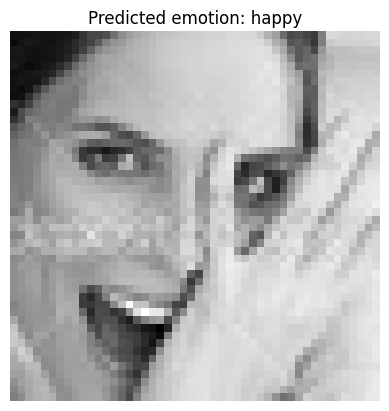

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Upload your image if not already in Colab
from google.colab import files
uploaded = files.upload()  # choose the image

# Get the uploaded file path
image_path = list(uploaded.keys())[0]
print("Original image uploaded:", image_path)

# Preprocess for model
def ef(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(48,48))
    feature = img_to_array(img)
    feature = feature.reshape(1,48,48,1)
    return feature / 255.0

img_for_model = ef(image_path)

# Predict
pred = model.predict(img_for_model)
pred_label = label[pred.argmax()]
print("Model prediction:", pred_label)

# Display the image
img_to_show = load_img(image_path, color_mode='grayscale', target_size=(48,48))
plt.imshow(img_to_show, cmap='gray')
plt.title(f"Predicted emotion: {pred_label}")
plt.axis('off')
plt.show()


Saving 909.jpg to 909 (1).jpg
Original image uploaded: 909 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Model prediction: surprise


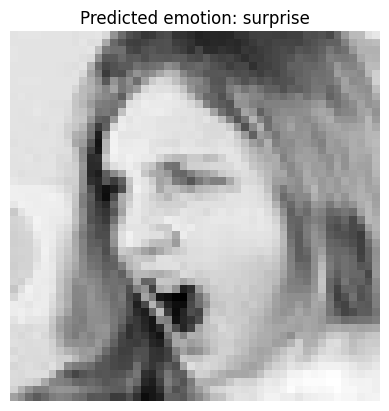

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Upload your image if not already in Colab
from google.colab import files
uploaded = files.upload()  # choose the image

# Get the uploaded file path
image_path = list(uploaded.keys())[0]
print("Original image uploaded:", image_path)

# Preprocess for model
def ef(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(48,48))
    feature = img_to_array(img)
    feature = feature.reshape(1,48,48,1)
    return feature / 255.0

img_for_model = ef(image_path)

# Predict
pred = model.predict(img_for_model)
pred_label = label[pred.argmax()]
print("Model prediction:", pred_label)

# Display the image
img_to_show = load_img(image_path, color_mode='grayscale', target_size=(48,48))
plt.imshow(img_to_show, cmap='gray')
plt.title(f"Predicted emotion: {pred_label}")
plt.axis('off')
plt.show()


Saving 986.jpg to 986 (1).jpg
Original image uploaded: 986 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Model prediction: sad


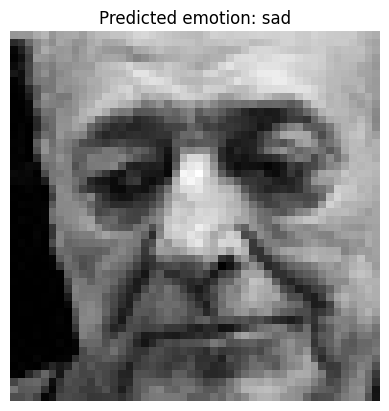

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Upload your image if not already in Colab
from google.colab import files
uploaded = files.upload()  # choose the image

# Get the uploaded file path
image_path = list(uploaded.keys())[0]
print("Original image uploaded:", image_path)

# Preprocess for model
def ef(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(48,48))
    feature = img_to_array(img)
    feature = feature.reshape(1,48,48,1)
    return feature / 255.0

img_for_model = ef(image_path)

# Predict
pred = model.predict(img_for_model)
pred_label = label[pred.argmax()]
print("Model prediction:", pred_label)

# Display the image
img_to_show = load_img(image_path, color_mode='grayscale', target_size=(48,48))
plt.imshow(img_to_show, cmap='gray')
plt.title(f"Predicted emotion: {pred_label}")
plt.axis('off')
plt.show()


Saving 970.jpg to 970.jpg
Original image uploaded: 970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Model prediction: neutral


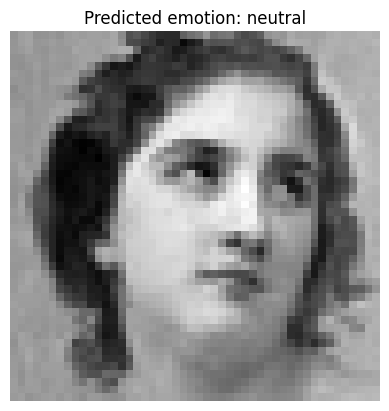

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Upload your image if not already in Colab
from google.colab import files
uploaded = files.upload()  # choose the image

# Get the uploaded file path
image_path = list(uploaded.keys())[0]
print("Original image uploaded:", image_path)

# Preprocess for model
def ef(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(48,48))
    feature = img_to_array(img)
    feature = feature.reshape(1,48,48,1)
    return feature / 255.0

img_for_model = ef(image_path)

# Predict
pred = model.predict(img_for_model)
pred_label = label[pred.argmax()]
print("Model prediction:", pred_label)

# Display the image
img_to_show = load_img(image_path, color_mode='grayscale', target_size=(48,48))
plt.imshow(img_to_show, cmap='gray')
plt.title(f"Predicted emotion: {pred_label}")
plt.axis('off')
plt.show()


Saving 96.jpg to 96.jpg
Original image uploaded: 96.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Model prediction: fear


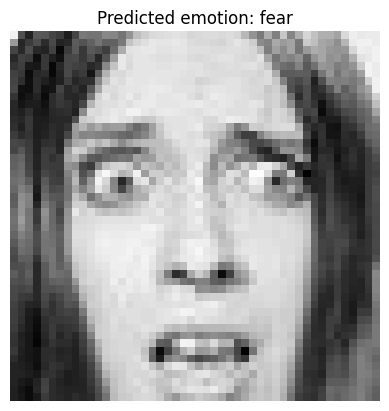

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Upload your image if not already in Colab
from google.colab import files
uploaded = files.upload()  # choose the image

# Get the uploaded file path
image_path = list(uploaded.keys())[0]
print("Original image uploaded:", image_path)

# Preprocess for model
def ef(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(48,48))
    feature = img_to_array(img)
    feature = feature.reshape(1,48,48,1)
    return feature / 255.0

img_for_model = ef(image_path)

# Predict
pred = model.predict(img_for_model)
pred_label = label[pred.argmax()]
print("Model prediction:", pred_label)

# Display the image
img_to_show = load_img(image_path, color_mode='grayscale', target_size=(48,48))
plt.imshow(img_to_show, cmap='gray')
plt.title(f"Predicted emotion: {pred_label}")
plt.axis('off')
plt.show()


Saving 845.jpg to 845.jpg
Original image uploaded: 845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Model prediction: disgust


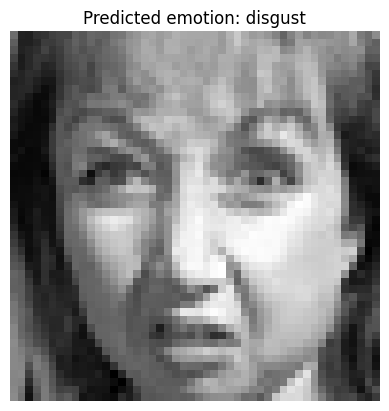

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Upload your image if not already in Colab
from google.colab import files
uploaded = files.upload()  # choose the image

# Get the uploaded file path
image_path = list(uploaded.keys())[0]
print("Original image uploaded:", image_path)

# Preprocess for model
def ef(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(48,48))
    feature = img_to_array(img)
    feature = feature.reshape(1,48,48,1)
    return feature / 255.0

img_for_model = ef(image_path)

# Predict
pred = model.predict(img_for_model)
pred_label = label[pred.argmax()]
print("Model prediction:", pred_label)

# Display the image
img_to_show = load_img(image_path, color_mode='grayscale', target_size=(48,48))
plt.imshow(img_to_show, cmap='gray')
plt.title(f"Predicted emotion: {pred_label}")
plt.axis('off')
plt.show()


Saving 974.jpg to 974.jpg
Original image uploaded: 974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Model prediction: angry


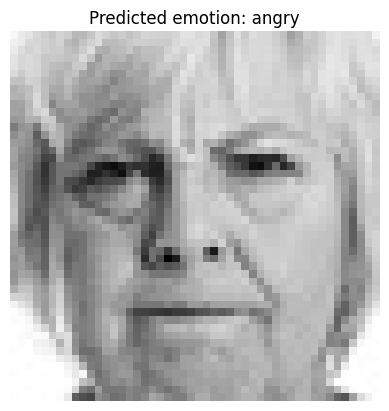

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Upload your image if not already in Colab
from google.colab import files
uploaded = files.upload()  # choose the image

# Get the uploaded file path
image_path = list(uploaded.keys())[0]
print("Original image uploaded:", image_path)

# Preprocess for model
def ef(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(48,48))
    feature = img_to_array(img)
    feature = feature.reshape(1,48,48,1)
    return feature / 255.0

img_for_model = ef(image_path)

# Predict
pred = model.predict(img_for_model)
pred_label = label[pred.argmax()]
print("Model prediction:", pred_label)

# Display the image
img_to_show = load_img(image_path, color_mode='grayscale', target_size=(48,48))
plt.imshow(img_to_show, cmap='gray')
plt.title(f"Predicted emotion: {pred_label}")
plt.axis('off')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
